# 🧪 Node classification with `kglab` and PyTorch Geometric

We introduce the application of neural networks on knowledge graphs using `kglab`. 

Graph Neural networks (GNNs) have gained popularity in a number of practical applications, including knowledge graphs, social networks and recommender systems. In the context of knowledge graphs, GNNs are being used for tasks such as link prediction, node classification or knowledge graph embeddings. Many use cases for these tasks are related to `Automatic Knowledge Base Construction` (AKBC) and completion.

In this tutorial, we will learn to:

- use `kglab` to represent a knowledge graph as a Pytorch Tensor, a suitable structure working with PyTorch neural nets

- use the widely known `pytorch_geometric` (PyG) GNN library together with `kglab`.

- train a GNN with `pytorch_geometric` and `PyTorch Lightning` for semi-supervised node classification of the recipes knowledge graph.

- build and iterate on training data using `rubrix` with a Human-in-the-loop (HITL) approach.

## Our use case in a nutshell

Our goal in this notebook will be to build a semi-supervised node classifier of recipes and ingredients from scratch using kglab, PyG and Rubrix. 

Our classifier will be able to classify the nodes in our 15K nodes knowledge graph according to a set of pre-defined flavour related categories: `sweet`, `salty`, `piquant`, `sour`, etc. To account for mixed flavours (e.g., sweet chili sauce), our model will be multi-class (we have several target labels), multi-label (a node can be labelled as with 0 or several categories).

## Install `kglab` and `Pytorch Geometric`

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
!pip install torch-geometric -qqq
!pip install torch -qqq

!pip install kglab -qqq

## 1. Loading and exploring the recipes knowledge graph

We'll be working with the "recipes" knowledge graph, which is used throughout the `kglab` tutorial (see the [Syllabus](https://derwen.ai/docs/kgl/tutorial/)).

This version of the recipes kg contains around ~15K recipes linked to their respective ingredients, as well as some other properties such as cooking time, labels and descriptions. 

Let's load the knowledge graph into a `kg` object by reading from an RDF file (in Turtle):

In [2]:
import kglab

NAMESPACES = {
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "recipe":  "https://www.food.com/recipe/",
    }

kg = kglab.KnowledgeGraph(namespaces = NAMESPACES)

_ = kg.load_rdf("data/recipe_lg.ttl")

Let's take a look at our graph structure using the `Measure` class:

In [3]:
measure = kglab.Measure()
measure.measure_graph(kg)

f"Nodes: {measure.get_node_count()} ; Edges: {measure.get_edge_count()}"

'Nodes: 15983 ; Edges: 160980'

In [4]:
measure.p_gen.get_tally() # tallies the counts of predicates

,count
http://purl.org/heals/food/hasIngredient,113537
http://www.w3.org/1999/02/22-rdf-syntax-ns#type,15981
http://www.w3.org/2004/02/skos/core#definition,15481
http://purl.org/heals/food/hasCookTime,15407
http://www.w3.org/2004/02/skos/core#prefLabel,574


In [5]:
measure.s_gen.get_tally() # tallies the counts of predicates

,count
https://www.food.com/recipe/67888,25
https://www.food.com/recipe/501028,25
https://www.food.com/recipe/277843,24
https://www.food.com/recipe/38276,24
https://www.food.com/recipe/64045,23
...,...
http://purl.org/heals/ingredient/buttermilk,2
http://purl.org/heals/ingredient/ground_pepper,2
http://purl.org/heals/ingredient/dill_weed,2
http://purl.org/heals/ingredient/cornbread_mix,2


In [6]:
measure.o_gen.get_tally() # tallies the counts of predicates

,count
http://purl.org/heals/food/Recipe,15407
http://purl.org/heals/ingredient/Salt,9034
http://purl.org/heals/ingredient/AllPurposeFlour,6456
http://purl.org/heals/ingredient/ChickenEgg,6041
http://purl.org/heals/ingredient/WhiteSugar,5979
...,...
http://purl.org/heals/ingredient/salt_free_herb_and_spice_seasoning_mix,1
http://purl.org/heals/ingredient/dry_onion_flakes,1
http://purl.org/heals/ingredient/black_cumin,1
http://purl.org/heals/ingredient/fine_semolina,1


In [7]:
measure.l_gen.get_tally() # tallies the counts of literals

,count
PT30M,1129
PT20M,1074
PT25M,956
PT10M,938
PT15M,906
...,...
roley poley pork roll,1
racheal s dill potato salad,1
hungarian cookie bars,1
fresno french toast,1


From the above exploration, we can extract some conclusions to guide the next steps:

- We have a limited number of relationships, being `hasIngredient` the most frequent.

- We have rather unique literals for labels and descriptions, but a certain amount of repetition for `hasCookTime`.

- As we would have expected, most frequently referenced objects are ingredients such as `Salt`, `ChikenEgg` and so on. 


Now, let's move into preparing our knowledge graph for PyTorch.

## 2. Representing our knowledge graph as a `PyTorch` Tensor

Let's now represent our `kg` as a `PyTorch` tensor using the `kglab.SubgraphTensor` class.

In [8]:
sg = kglab.SubgraphTensor(kg)

In [9]:
def tensorify(g, sg, excludes):
    def exclude(rel):
        return sg.n3fy(rel) in excludes
    
    relations = sorted(set(g.predicates()))
    subjects = set(g.subjects())
    objects = set(g.objects())
    nodes = list(subjects.union(objects))
    
    relations_dict = {rel: i for i, rel in enumerate(list(relations)) if not exclude(rel)}
    
    # this offset enables consecutive indices in our final vector
    offset = len(relations_dict.keys())
    
    nodes_dict = {node: i+offset for i, node in enumerate(nodes)}

    
    edge_list = []
    
    for s, p, o in g.triples((None, None, None)):
        if p in relations_dict.keys(): # this means is not excluded
            src, dst, rel = nodes_dict[s], nodes_dict[o], relations_dict[p]
            edge_list.append([src, dst, 2 * rel])
            edge_list.append([dst, src, 2 * rel + 1])
    
    # turn into str keys and concat
    node_vector = [sg.n3fy(node) for node in relations_dict.keys()] + [sg.n3fy(node) for node in nodes_dict.keys()]
    return edge_list, node_vector

In [10]:
edge_list, node_vector = tensorify(kg.rdf_graph(), sg, excludes=['skos:description', 'skos:prefLabel'])

In [11]:
len(edge_list)

320812

Let's create `kglab.Subgraph` to be used for encoding/decoding numerical ids and uris, which will be useful for preparing our training data, as well as making sense of the predictions of our neural net.

In [12]:
sg = kglab.Subgraph(kg=kg, preload=node_vector)

In [13]:
import torch
from torch_geometric.data import Data

tensor = torch.tensor(edge_list, dtype=torch.long).t().contiguous() 
edge_index, edge_type = tensor[:2], tensor[2]
data = Data(edge_index=edge_index)
data.edge_type = edge_type

In [14]:
(data.edge_index.shape, data.edge_type.shape, data.edge_type.max())

(torch.Size([2, 320812]), torch.Size([320812]), tensor(7))

## 3. Building a training set with Rubrix

Now that we have a tensor representation of our kg which we can feed into our neural network, let's now focus on the training data.

As we will be doing semi-supervised classification, we need to build a training set (i.e., some recipes and ingredients with ground-truth labels). 


For this, we can use [Rubrix](https://github.com/recognai/rubrix), an open-source tool for exploring, labeling and iterating on data for AI. Rubrix allows data scientists and subject matter experts to rapidly iterate on training and evaluation data by enabling iterative, asynchronous and potentially distributed workflows.

In Rubrix, a very simple workflow during model development looks like this:

1. Log unlabelled data records with `rb.log()` into a Rubrix dataset. At this step you could use weak supervision methods (e.g., Snorkel) to pre-populate and then only refine the suggested labels, or use a pretrained model to guide your annotation process. In our case, we will just log recipe and ingredient "records" along with some metadata (RDF types, labels, etc.).

2. Rapidly explore and label records in your dataset using the webapp which follows a search-driven approach, which is especially useful with large, potentially noisy datasets and for quickly leveraging domain knowledge (e.g., recipes containing WhiteSugar are likely sweet). For the tutorial, we have spent around 30min for labelling around 600 records.

3. Retrieve your annotations any time using `rb.load()` or `rb.snapshot()`, which return a convenient `pd.Dataframe` making it quite handy to process and use for model development. In our case, we will load a snapshot, do a train_test_split with scikit_learn, and then use this for training our GNN.

4. After training a model, you can go back to step 1, this time using your model and its predictions, to spot improvements, quickly label other portions of the data, and so on. In our case, as we've started with a very limited training set (~600 examples), we will use our node classifier and `rb.log()` it's predictions over the rest of our data (unlabelled recipes and ingredients).

In [15]:
LABELS = ['Bitter', 'Meaty', 'Piquant', 'Salty', 'Sour', 'Sweet']

### Setup Rubrix

If you have not installed and launched Rubrix, check the [installation guide](https://github.com/recognai/rubrix#get-started). 

In [ ]:
import rubrix as rb

### 0. Preparing our raw dataset of recipes and ingredients

In [26]:
import pandas as pd
sparql = """
    SELECT distinct *
    WHERE {
        ?uri a wtm:Recipe .
        ?uri a ?type .
        ?uri skos:definition ?definition .
        ?uri wtm:hasIngredient ?ingredient
    } 
"""
df = kg.query_as_df(sparql=sparql)

# We group the ingredients into one column containing lists:
recipes_df = df.groupby(['uri', 'definition', 'type'])['ingredient'].apply(list).reset_index(name='ingredients') ; recipes_df

sparql_ingredients = """
    SELECT distinct *
    WHERE {
        ?uri a wtm:Ingredient .
        ?uri a ?type .
        OPTIONAL { ?uri skos:prefLabel ?definition } 
    }
"""

df = kg.query_as_df(sparql=sparql_ingredients)
df['ingredients'] = None

ing_recipes_df = pd.concat([recipes_df, df]).reset_index(drop=True)

ing_recipes_df.fillna('', inplace=True) ; ing_recipes_df

,uri,definition,type,ingredients
0,recipe:10000,tomato paste,wtm:Recipe,"[ind:Salt, ind:Tomato]"
1,recipe:100026,baking powder meatballs,wtm:Recipe,"[ind:BlackPepper, ind:Salt, ind:ground_beef, i..."
2,recipe:100034,working woman s cheese souffle,wtm:Recipe,"[ind:CowMilk, ind:Butter, ind:AllPurposeFlour,..."
3,recipe:100048,carrot spice cookies,wtm:Recipe,"[ind:cinnamon, ind:margarine, ind:Salt, ind:Ba..."
4,recipe:100051,2 minute mayonnaise,wtm:Recipe,"[ind:AppleCiderVinegar, ind:sweetened_condense..."
...,...,...,...,...
15976,ind:bean_sprouts,bean sprouts,wtm:Ingredient,
15977,ind:grand_marnier,grand marnier,wtm:Ingredient,
15978,ind:salt_pepper,salt & pepper,wtm:Ingredient,
15979,ind:asian_chili_sauce,asian chili sauce,wtm:Ingredient,


### Logging into Rubrix

In [ ]:
import rubrix as rb

records = []
for i, r in ing_recipes_df.iterrows():
    item = rb.TextClassificationRecord(
            inputs={
                "id":r.uri, 
                "definition": r.definition,
                "ingredients": str(r.ingredients), 
                "type": r.type
            }, # log node fields
            prediction=[(label, 0.0) for label in LABELS], # log "dummy" predictions for aiding annotation
            metadata={'ingredients': r.ingredients, "type": r.type}, # metadata filters for quick exploration and annotation
            prediction_agent="kglab_tutorial", # who's performing/logging the prediction
            multi_label=True
        )
    records.append(item)
rb.log(records=records, name="kg_classification_tutorial")

### Annotation session with Rubrix (optional)

In this step you can go to your rubrix dataset and annotate some examples of each class.

If you have no time to do this, just skip this part as we have prepared a dataset for you with around ~600 examples.

### Loading our labelled records and create a train_test split (optional)

In this step you can go to your rubrix dataset and annotate some examples of each class.

If you have no time to do this, just skip this part as we have prepared a dataset for you.

In [ ]:
rb.snapshots(dataset="kg_node_classification")

In [ ]:
df = rb.load(name="kg_node_classification", snapshot='1619530026.060097') ; df.head()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df)
train_df.to_csv('data/train_recipes_new.csv')
test_df.to_csv('data/test_recipes_new.csv')

### Creating PyTorch train and test sets

Here we take our train and test datasets and transform them into `torch.Tensor` objects with the help of our kglab `Subgraph` for turning `uris` into `torch.long` indices.

In [16]:
import pandas as pd

train_df = pd.read_csv('data/train_recipes.csv') # use your own labelled datasets if you've created a snapshot
test_df = pd.read_csv('data/test_recipes.csv')

# we make sure lists are parsed correctly
train_df.labels = train_df.labels.apply(eval)
test_df.labels = test_df.labels.apply(eval)

Let's create label lookups for label to int and viceversa

In [17]:
label2id = {label:i for i,label in enumerate(LABELS)} ; 
id2label = {i:l for l,i in label2id.items()} ; (id2label, label2id)

({0: 'Bitter', 1: 'Meaty', 2: 'Piquant', 3: 'Salty', 4: 'Sour', 5: 'Sweet'},
 {'Bitter': 0, 'Meaty': 1, 'Piquant': 2, 'Salty': 3, 'Sour': 4, 'Sweet': 5})

The following function turns our DataFrame into numerical arrays for node indices and labels

In [18]:
import numpy as np

def create_indices_labels(df):
    # turn our dense labels into a one-hot list
    def one_hot(label_ids):
        a = np.zeros(len(LABELS))
        a.put(label_ids, np.ones(len(label_ids)))
        return a
    
    indices, labels = [], []
    for uri, label in zip(df.uri.tolist(), df.labels.tolist()):
        indices.append(sg.transform(uri))
        labels.append(one_hot([label2id[label] for label in label]))
    return indices, labels

Finally, let's turn our dataset into PyTorch tensors

In [19]:
train_indices, train_labels = create_indices_labels(train_df)
test_indices, test_labels = create_indices_labels(test_df)

train_idx = torch.tensor(train_indices, dtype=torch.long)
train_y = torch.tensor(train_labels, dtype=torch.float)

test_idx = torch.tensor(test_indices, dtype=torch.long)
test_y = torch.tensor(test_labels, dtype=torch.float) ; train_idx[:10], train_y

(tensor([10411,   754, 32067, 30506, 21830,  4204,   200,  9817,  1215,  8512]),
 tensor([[0., 0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1.],
         ...,
         [0., 1., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [1., 0., 1., 0., 0., 1.]]))

Let's see if we can recover the correct URIs for our numerical ids using our `kglab.Subgraph`

In [23]:
(train_df.loc[0], sg.inverse_transform(10411))

(Unnamed: 0                                                      0
 Unnamed: 0.1                                                   64
 index                                                          64
 id                                                         214252
 ingredients     ['ind:AllPurposeFlour', 'ind:whipping_cream', ...
 type                                                   wtm:Recipe
 labels                                              [Sweet, Sour]
 definition      noni s sour cream chocolate cake with brown su...
 uri                                                 recipe:214252
 Name: 0, dtype: object,
 'recipe:214252')

## 4. Creating a Subgraph of recipe and ingredient nodes
Here we create a node list to be used as a seed for building our `PyG` subgraph (using k-hops as we will see in the next section). The reason is that we do not want to encode all nodes in the graph (such as literals, durations, etc.). Our goal would be to encode only `recipes` and `ingredients`, as all nodes passed through the GNN will be classified. 

In [27]:
node_idx = torch.LongTensor([
    sg.transform(i) for i in ing_recipes_df.uri.values
])

In [28]:
node_idx.max(), node_idx.shape

(tensor(32258), torch.Size([15981]))

In [29]:
ing_recipes_df.iloc[1]

uri                                                recipe:100026
definition                               baking powder meatballs
type                                                  wtm:Recipe
ingredients    [ind:BlackPepper, ind:Salt, ind:ground_beef, i...
Name: 1, dtype: object

In [30]:
sg.inverse_transform(node_idx[1])

'recipe:100026'

## 5. Semi-supervised node classification with PyTorch Geometric


### Graph Convolutional Networks


### PyTorch Geometric

### Creating a `PyG` subgraph

Here we build a subgraph with `k` hops from target to source starting with all `recipe` and `ingredient` nodes:

In [31]:
from torch_geometric.utils import k_hop_subgraph
# here we take all connected nodes with k hops
k = 1
node_idx, edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx, 
    k, 
    data.edge_index, 
    relabel_nodes=False
)

We have increased the size of our node set:

In [32]:
node_idx.shape

torch.Size([31712])

In [33]:
data.edge_index.shape

torch.Size([2, 320812])

Here we compute some measures needed for defining the size of our layers

In [34]:
data.edge_index = edge_index

data.num_nodes = data.edge_index.max().item() + 1

data.num_relations = data.edge_type.max().item() + 1

data.edge_type = data.edge_type[edge_mask]

data.num_classes = len(LABELS)

data.num_nodes, data.num_relations, data.num_classes

(32263, 8, 6)

### Defining a basic Relational Graph Convolutional Network

In [35]:
from torch_geometric.nn import FastRGCNConv, RGCNConv
import torch.nn.functional as F

In [36]:
RGCNConv?

Init signature:
RGCNConv(
    in_channels: Union[int, Tuple[int, int]],
    out_channels: int,
    num_relations: int,
    num_bases: Union[int, NoneType] = None,
    num_blocks: Union[int, NoneType] = None,
    aggr: str = 'mean',
    root_weight: bool = True,
    bias: bool = True,
    **kwargs,
)
Docstring:     
The relational graph convolutional operator from the `"Modeling
Relational Data with Graph Convolutional Networks"
<https://arxiv.org/abs/1703.06103>`_ paper

.. math::
    \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
    \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
    \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
stores a relation identifier
:math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

.. note::
    This implementation is as memory-efficient as possi

In [37]:
class RGCN(torch.nn.Module):
    def __init__(self, num_nodes, num_relations, num_classes, out_channels=16, num_bases=30, dropout=0.0, layer_type=FastRGCNConv, ):
        
        super(RGCN, self).__init__()
        
        self.conv1 = layer_type(
            num_nodes, 
            out_channels, 
            num_relations, 
            num_bases=num_bases
        )
        self.conv2 = layer_type(
            out_channels, 
            num_classes, 
            num_relations, 
            num_bases=num_bases
        )
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.conv1(None, edge_index, edge_type))
        x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_type)
        return torch.sigmoid(x)

### Create  and visualizing our model

In [204]:
model = RGCN(
    num_nodes=data.num_nodes,
    num_relations=data.num_relations,
    num_classes=data.num_classes,
    #out_channels=64,
    dropout=0.2,
    layer_type=RGCNConv
) ; model

RGCN(
  (conv1): RGCNConv(32263, 16, num_relations=8)
  (conv2): RGCNConv(16, 6, num_relations=8)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pytorch_lightning.metrics.utils import to_categorical

def visualize(h, color, labels):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    legend = plt.legend(scatter.legend_elements()[0],labels, loc="upper right", title="Labels",) #*scatter.legend_elements()
    plt.show()

In [205]:
pred = model(edge_index, edge_type)

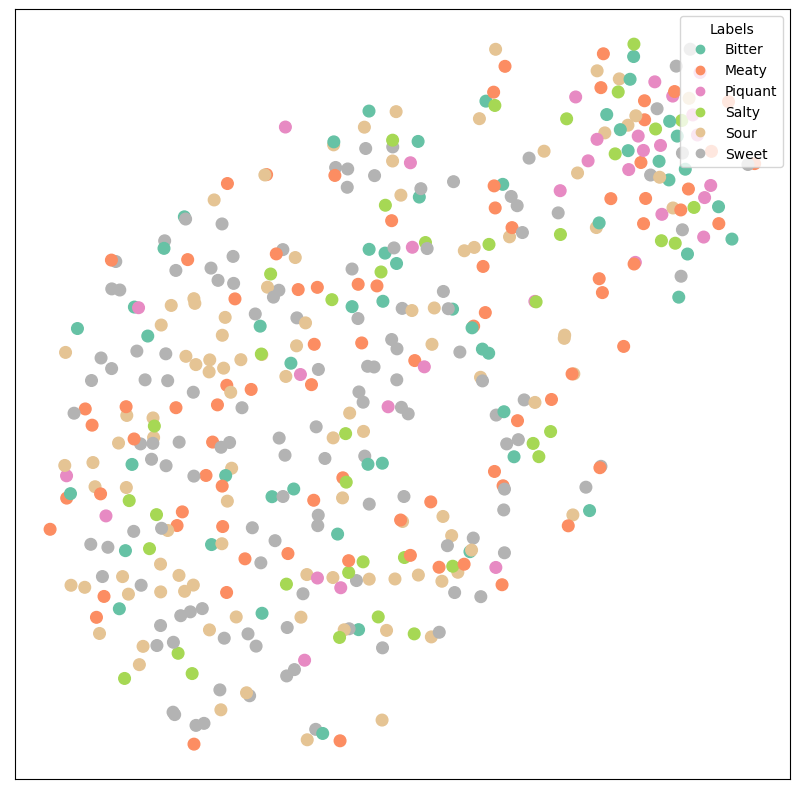

In [206]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)

### Training our RGCN

In [208]:
device = torch.device('cpu') # ('cuda')
data = data.to(device)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters())
loss_module = torch.nn.BCELoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = loss_module(out[train_idx], train_y)
    loss.backward()
    optimizer.step()
    return loss.item()

def accuracy(predictions, y):
    predictions = np.round(predictions)
    return predictions.eq(y).to(torch.float).mean()

@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type)
    train_acc = accuracy(pred[train_idx], train_y)
    test_acc = accuracy(pred[test_idx], test_y)
    return train_acc.item(), test_acc.item()

In [209]:
for epoch in range(1, 50):
    loss = train()
    train_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f} '
          f'Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.6931, Train: 0.7608 Test: 0.6926
Epoch: 02, Loss: 0.6811, Train: 0.8020 Test: 0.7241
Epoch: 03, Loss: 0.6693, Train: 0.8167 Test: 0.7432
Epoch: 04, Loss: 0.6557, Train: 0.8178 Test: 0.7477
Epoch: 05, Loss: 0.6456, Train: 0.8228 Test: 0.7477
Epoch: 06, Loss: 0.6304, Train: 0.8265 Test: 0.7489
Epoch: 07, Loss: 0.6194, Train: 0.8292 Test: 0.7489
Epoch: 08, Loss: 0.6084, Train: 0.8337 Test: 0.7556
Epoch: 09, Loss: 0.5890, Train: 0.8382 Test: 0.7579
Epoch: 10, Loss: 0.5761, Train: 0.8428 Test: 0.7635
Epoch: 11, Loss: 0.5661, Train: 0.8473 Test: 0.7680
Epoch: 12, Loss: 0.5445, Train: 0.8519 Test: 0.7736
Epoch: 13, Loss: 0.5327, Train: 0.8553 Test: 0.7793
Epoch: 14, Loss: 0.5208, Train: 0.8568 Test: 0.7860
Epoch: 15, Loss: 0.5091, Train: 0.8587 Test: 0.7905
Epoch: 16, Loss: 0.4851, Train: 0.8598 Test: 0.7950
Epoch: 17, Loss: 0.4744, Train: 0.8621 Test: 0.7962
Epoch: 18, Loss: 0.4590, Train: 0.8632 Test: 0.7962
Epoch: 19, Loss: 0.4491, Train: 0.8651 Test: 0.7984
Epoch: 20, L

### Model visualization

In [212]:
pred = model(edge_index, edge_type)

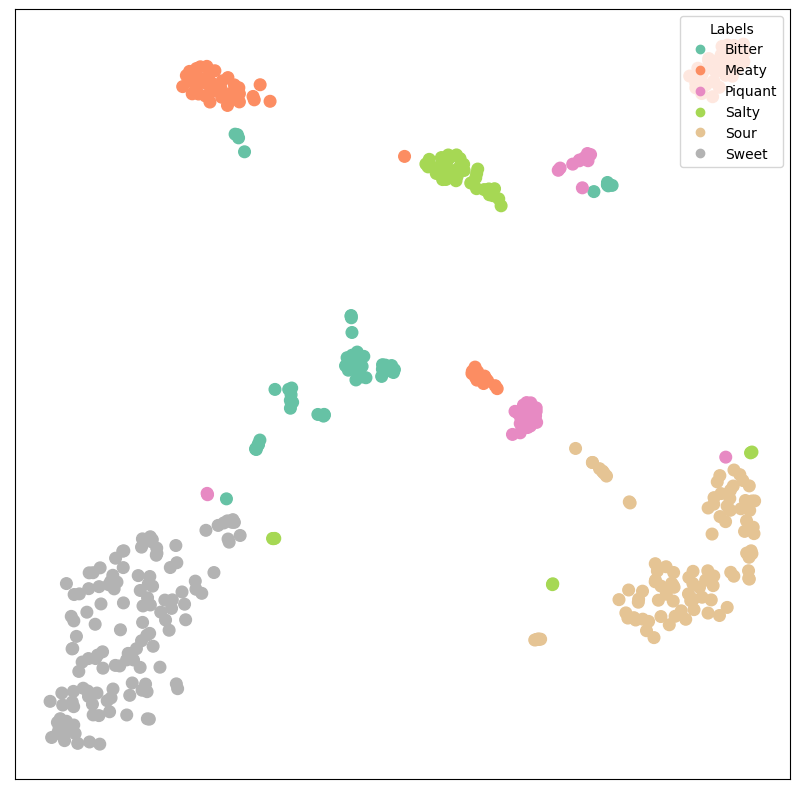

In [214]:
visualize(pred[train_idx], color=to_categorical(train_y), labels=LABELS)

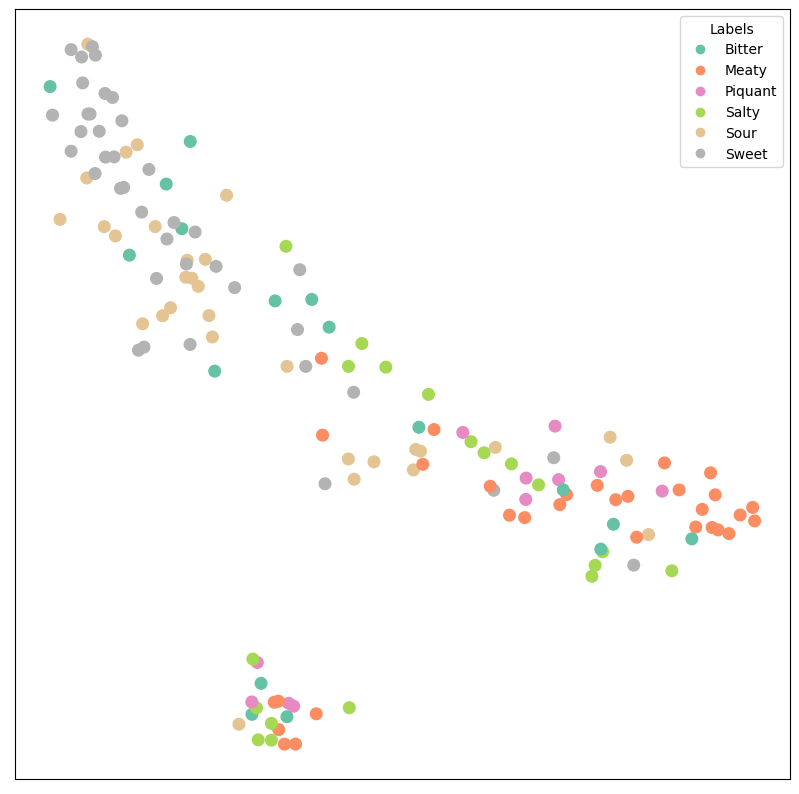

In [215]:
visualize(pred[test_idx], color=to_categorical(test_y), labels=LABELS)

## 6. Using our model and analyzing its predictions with Rubrix
Let's see the shape of our model predictions

In [42]:
pred = model(edge_index, edge_type) ; pred

tensor([[0.5067, 0.4738, 0.4889, 0.4978, 0.5079, 0.5016],
        [0.5072, 0.4745, 0.4906, 0.5009, 0.5045, 0.5019],
        [0.5043, 0.4783, 0.4862, 0.5019, 0.5027, 0.4971],
        ...,
        [0.2726, 0.3583, 0.6448, 0.4166, 0.5208, 0.3931],
        [0.2742, 0.3746, 0.6723, 0.3505, 0.6111, 0.4625],
        [0.2902, 0.3643, 0.6656, 0.3921, 0.6403, 0.5343]],
       grad_fn=<SigmoidBackward>)

In [ ]:
def find(tensor, values):
    return torch.nonzero(tensor[..., None] == values)

### Analizing predictions over the test set

In [ ]:
test_idx = find(node_idx,test_idx)[:,0] ; len(test_idx)

In [ ]:
index = torch.zeros(node_idx.shape[0], dtype=bool)
index[test_idx] = True
idx = node_idx[index]

In [ ]:
uris = [sg.inverse_transform(i) for i in idx]
predicted_labels = [l for l in pred[idx]]

In [ ]:
predictions = list(zip(uris,predicted_labels)) ; predictions[0:2]

In [ ]:
import rubrix as rb

records = []
for uri,predicted_labels in predictions:
    ids = ing_recipes_df.index[ing_recipes_df.uri == uri]
    if len(ids) > 0:
        r = ing_recipes_df.iloc[ids]
        # get the gold labels from our test set
        gold_labels = test_df.iloc[test_df.index[test_df.uri == uri]].labels.values[0]
        item = rb.TextClassificationRecord(
                inputs={"id":r.uri.values[0], "definition": r.definition.values[0], "ingredients": str(r.ingredients.values[0]), "type": r.type.values[0]}, 
                prediction=[(id2label[i], score) for i,score in enumerate(predicted_labels)],
                annotation=gold_labels,
                metadata={'ingredients': r.ingredients.values[0], "type": r.type.values[0]}, 
                prediction_agent="node_classifier_v1", 
                multi_label=True
        )
        records.append(item)

In [ ]:
rb.log(records, name="kg_node_classification_test")

### Analizing predictions over unseen nodes (and potentially relabeling them)

Let's find the ids for the nodes in our training and test sets

In [ ]:
train_test_idx = find(node_idx,torch.cat((test_idx, train_idx)))[:,0] ; len(train_test_idx)

Let's get the ids, uris and labels of the nodes which were not in our train/test datasets

In [ ]:
index = torch.ones(node_idx.shape[0], dtype=bool)
index[train_test_idx] = False
idx = node_idx[index]

We use our `SubgraphTensor` for getting back our URIs and build `uri,predicted_labels` pairs:

In [ ]:
uris = [sg.inverse_transform(i) for i in idx]
predicted_labels = [l for l in pred[idx]]

In [ ]:
predictions = list(zip(uris,predicted_labels)) ; predictions[0:2]

In [ ]:
import rubrix as rb

records = []
for uri,predicted_labels in predictions:
    ids = ing_recipes_df.index[ing_recipes_df.uri == uri]
    if len(ids) > 0:
        r = ing_recipes_df.iloc[ids]
        item = rb.TextClassificationRecord(
                inputs={"id":r.uri.values[0], "definition": r.definition.values[0], "ingredients": str(r.ingredients.values[0]), "type": r.type.values[0]}, 
                prediction=[(id2label[i], score) for i,score in enumerate(predicted_labels)], 
                metadata={'ingredients': r.ingredients.values[0], "type": r.type.values[0]}, 
                prediction_agent="node_classifier_v1", 
                multi_label=True
        )
        records.append(item)

In [ ]:
rb.log(records, name="kg_node_classification_unseen_nodes_v3")

## Exercise 1: Training experiments with PyTorch Lightning

In [ ]:
#!pip install wandb -qqq # optional
!pip install pytorch_lightning

In [ ]:
!wandb login #optional

In [ ]:
from torch_geometric.data import Data, DataLoader

data.train_idx = train_idx
data.train_y = train_y
data.test_idx = test_idx
data.test_y = test_y

dataloader = DataLoader([data], batch_size=1); dataloader

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

class RGCNNodeClassification(pl.LightningModule):
    
    def __init__(self, **model_kwargs):
        super().__init__()
        
        self.model = RGCN(**model_kwargs)
        self.loss_module = torch.nn.BCELoss()
    
    def forward(self, edge_index, edge_type):
        return self.model(edge_index, edge_type)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.001)
        return optimizer
        
    def training_step(self, batch, batch_idx):
        idx, y = data.train_idx, data.train_y
        edge_index, edge_type = data.edge_index, data.edge_type
        x = self.forward(edge_index, edge_type)
        loss = self.loss_module(x[idx], y)
        x = x.detach()
        self.log('train_acc', accuracy(x[idx], y), prog_bar=True)
        self.log('train_loss', loss)
        return loss 
        
    def validation_step(self, batch, batch_idx):
        idx, y = data.test_idx, data.test_y
        edge_index, edge_type = data.edge_index, data.edge_type
        x = self.forward(edge_index, edge_type)
        loss = self.loss_module(x[idx], y)
        x = x.detach()
        self.log('val_acc', accuracy(x[idx], y), prog_bar=True)
        self.log('val_loss', loss)

In [ ]:
pl.seed_everything()

In [ ]:
model_pl = RGCNNodeClassification(
    num_nodes=data.num_nodes,
    num_relations=data.num_relations,
    num_classes=data.num_classes,
    #out_channels=64,
    dropout=0.2,
    layer_type=RGCNConv
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_acc', patience=10, mode='max')

In [ ]:
trainer = pl.Trainer(
    default_root_dir='pl_runs',
    checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
    max_epochs=200,
    #logger= WandbLogger(), # optional
    callbacks=[earlystopping]
)

In [ ]:
trainer.fit(model_pl, dataloader, dataloader)

## Exercise 2: Bootstrapping annotation with a zeroshot-classifier

In [1]:
!pip install transformers -qqq

In [23]:
from transformers import pipeline
  
pretrained_model =  "valhalla/distilbart-mnli-12-1" # "typeform/squeezebert-mnli"

pl = pipeline('zero-shot-classification', model=pretrained_model)

In [24]:
pl("chocolate cake", LABELS, hypothesis_template='The flavour is {}.',multi_label=True)

{'sequence': 'chocolate cake',
 'labels': ['Sweet', 'Piquant', 'Bitter', 'Salty', 'Meaty', 'Sour'],
 'scores': [0.6839402914047241,
  0.02114126645028591,
  0.0025301866699010134,
  0.001267178449779749,
  0.0004893316072411835,
  0.00013206301082391292]}

In [ ]:
import rubrix as rb

records = []
for i, r in ing_recipes_df.iterrows():
    item = rb.TextClassificationRecord(
            inputs={
                "id":r.uri, 
                "definition": r.definition,
                "ingredients": str(r.ingredients), 
                "type": r.type
            }, 
            prediction= # TODO: here we log he predictions of our zeroshot pipeline as a list of tuples (label, score)
            metadata={'ingredients': r.ingredients, "type": r.type}, 
            prediction_agent="valhalla/distilbart-mnli-12-1", 
            multi_label=True
        )
    records.append(item)
rb.log(records=records, name="kg_classification_tutorial_zeroshot")